# HW 2: Supervised Learning
Submitted by: Gideon Tay\
My UNI: gt2528\
Contact me at: gideon.tay@columbia.edu

# Part A: Regression on California test scores
## A1. Load in the data

In [1]:
# Import libraries needed for A1 to A3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load in the California Test Score Data Set
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Caschool.csv'
)

# Let's get a sense of how this data looks like
df.head(3)

,rownames,distcod,county,district,grspan,enrltot,teachers,calwpct,mealpct,computer,testscr,compstu,expnstu,str,avginc,elpct,readscr,mathscr
0,1,75119,Alameda,Sunol Glen Unified,KK-08,195,10.900000,0.510200,2.040800,67,690.799988,0.343590,6384.911133,17.889910,22.690001,0.000000,691.599976,690.000000
1,2,61499,Butte,Manzanita Elementary,KK-08,240,11.150000,15.416700,47.916698,101,661.200012,0.420833,5099.380859,21.524664,9.824000,4.583333,660.500000,661.900024
2,3,61549,Butte,Thermalito Union Elementary,KK-08,1550,82.900002,55.032299,76.322601,169,643.599976,0.109032,5501.954590,18.697226,8.978000,30.000002,636.299988,650.900024


## A2. Visualize the univariate distribution of `testscr` and 3 continuous explanatory variables

We will use a histogram overlaid with a kernel density estimate (KDE) plot to visualize the distributions. The histogram splits the data into discrete bins, while the KDE is a non-parametric estimate of the test scores' probability density function.

I posit that the 3 following variables likely have a relationship with `testscr`:

- `str`: student teacher ratio.
    - If `str` is high, each student is likely to get less attention and personalized help from their teacher. This may be linked to lower test scores (negative relationship).
- `mealpct`: percent qualifying for reduced-price lunch.
    - `mealpct` is a good proxy for identifying the percentage of students in a school district from low family income backgrounds. These students likely have less access to external learning opportunities like enrichment classes, and thus are more likely to have lower scores (negative relationship).
- `elpct`: percent of English learners.
    - Students who are English learners likely do not have English as their first language and would face greater difficulty learning in an English-based education system. Hence, they likely have lower test scores (negative relationship).


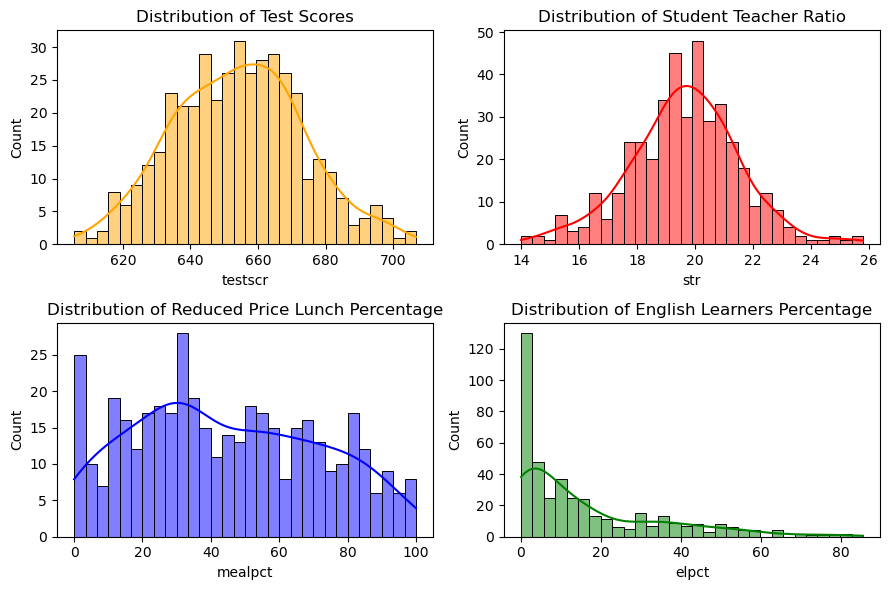

In [2]:
# Set up the figure size
plt.figure(figsize=(9, 6))

# Plot a histogram and kernel density estimate (KDE) plot for 'testscr'
plt.subplot(2, 2, 1) # 1st position in the 2x2 grid
sns.histplot(df['testscr'], kde = True, bins=30, color='orange') 
plt.title('Distribution of Test Scores')

# Plot for 'str' column
plt.subplot(2, 2, 2) # 2nd position in the 2x2 grid
sns.histplot(df['str'], kde=True, bins=30, color='red')
plt.title('Distribution of Student Teacher Ratio')

# Plot for 'mealpct' column
plt.subplot(2, 2, 3) # 3rd position in the 2x2 grid
sns.histplot(df['mealpct'], kde=True, bins=30, color='blue')
plt.title('Distribution of Reduced Price Lunch Percentage')

# Plot for 'elpct' column
plt.subplot(2, 2, 4) # 4th position in the 2x2 grid
sns.histplot(df['elpct'], kde=True, bins=30, color='green')
plt.title('Distribution of English Learners Percentage')

# Show the plots
plt.tight_layout() # Adjust layout for better spacing
plt.show()

Here are some brief observations from the plots:

- `testscr`'s distribution somewhat resembles a normal distribution. It is roughly symmetric with a single peak, and there are fewer scores further away from the peak.
- `str`'s distribution roughly resembles a normal distribution.
- `mealpct`'s distribution is somewhat flat, but not exactly a continuous uniform distribution either, as there are fewer school districts at very high values (>85%).
- `elpct`'s distribution is very right-skewed, with many school districts near 0%, and less and less districts at higher percentages.

## A3. Visualize `testscr`'s dependency on `str`, `mealpct`, and `elpct`
To visualize the relation between `testscr` and the 3 explanatory variables, we will plot 3 separate scatterplots with linear regression lines:

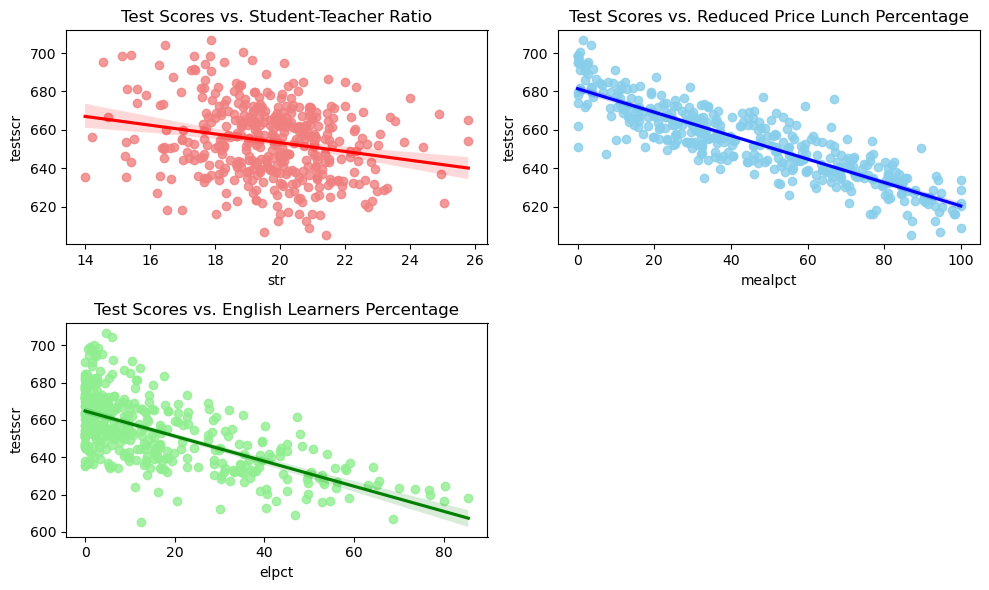

In [3]:
# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot for 'testscr' vs 'str'
plt.subplot(2, 2, 1) # 1st position in the 2x2 grid
sns.regplot(
    x='str', y='testscr', data=df, 
    scatter_kws={'color': 'lightcoral'}, 
    line_kws={'color': 'red'}
)
plt.title('Test Scores vs. Student-Teacher Ratio')
#plt.xlabel('Student-Teacher Ratio (str)')

# Plot for 'testscr' vs 'mealpct'
plt.subplot(2, 2, 2) # 2nd position in the 2x2 grid
sns.regplot(
    x='mealpct', y='testscr', data=df, 
    scatter_kws={'color': 'skyblue'}, 
    line_kws={'color': 'blue'}
)
plt.title('Test Scores vs. Reduced Price Lunch Percentage')

# Plot for 'testscr' vs 'elpct'
plt.subplot(2, 2, 3) # 3rd position in the 2x2 grid
sns.regplot(
    x='elpct', y='testscr', data=df, 
    scatter_kws={'color': 'lightgreen'}, 
    line_kws={'color': 'green'}
)
plt.title('Test Scores vs. English Learners Percentage')

# Show the plots
plt.tight_layout() # Adjust layout for better spacing
plt.show()

From the plots, it appears that `testscr` is negatively related with `str`, `mealpct`, and `elpct`. This is in line with our initial expectations as explained above.

## A4. Build and evaluate KNN, OLS, Ridge, and Lasso models

First, let's import all additional libaries needed for questions A4 to A6:

In [4]:
# Import additional sklearn libraries needed for A4 and A5
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

### Split the data into training and test sets
First identify the X variables we will work with:
- Exclude `readscr` and `mathscr` as they were used to generate `testscr`.
- Ignore non-quantitative variables in the dataset like `county`, `district`, and `grspan`.
- Do not consider `distcod` since this is a dataset of school district data, so there are no duplicate values in the `distcod` column and it provides no predictive value. Also, while district codes are numbers, they are categorical and discrete, rather than a continuous variable.

Our X variables are thus `enrltot`, `teachers`, `calwpct`, `mealpct`, `computer`, `compstu`, `expnstu`, `str`, `avginc`, and `elpct`. Our Y variable is `testscr`.

In [5]:
# Define the target column (y) and the feature columns (X)
y = df['testscr']
X = df[[
    'enrltot', 'teachers', 'calwpct', 'mealpct', 'computer', 
    'compstu', 'expnstu', 'str', 'avginc', 'elpct']]

# Split the data into training and test sets (By default: 75% training, 25% test)
# Assign a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Print the shape of the resulting sets
print('Training set X:', X_train.shape)
print('Test set X:', X_test.shape)
print('Training set Y:', y_train.shape)
print('Test set Y:', y_test.shape)

Training set X: (315, 10)
Test set X: (105, 10)
Training set Y: (315,)
Test set Y: (105,)


### Build and evaluate KNN, OLS, Ridge, and Lasso models
We conduct cross-validation with default parameters for each of the 4 models. By default, 
- R² is used for scoring
- We have a standard 5-fold cross validation without shuffling.
- KNN uses 5 neighbors
- Ridge and Lasso models use alpha = 1.0

We define a function `evaluate_models` that evaluates each model using cross-validation. 
- This function has a `scaling` argument that we can turn on or off (useful for the next question A5).
- It also has a `model_list` argument, which takes in lists of models and their names so we can easily test different models (useful for question B4 and B5 in Part B).

In [6]:
# List the models
# As testscr is continuous use KNeighborsRegressor not KNeighborsClassifier
models = [
    ('KNN', KNeighborsRegressor()),  # Default n_neighbors=5
    ('OLS', LinearRegression()), 
    ('Ridge', Ridge(max_iter=3000)), # Default alpha=1.0, max_iter to converge
    ('Lasso', Lasso(max_iter=3000))  # Default alpha=1.0, max_iter to converge
]

# Function to evaluate each model using cross-validation
def evaluate_models(X_train, y_train, model_list, scaling=False):
    results = []
    
    for name, model in model_list:
        # If scaling=True, make a pipeline that scales data before fitting data
        if scaling:
            pipe = make_pipeline(StandardScaler(), model)
            scores = cross_val_score(pipe, X_train, y_train)
        else:
            scores = cross_val_score(model, X_train, y_train)

        # Calculate mean and standard deviation of scores and store results
        mean_score = round(np.mean(scores), 3)
        std_score = round(np.std(scores), 3)
        results.append({
            'Model': name,
            'Mean Score': mean_score,
            'Standard Deviation': std_score
        })
        
    # Convert the results into a DataFrame for easy viewing
    results_df = pd.DataFrame(results)
    return results_df

# Evaluate models without StandardScaler and display results
results_no_scaling = evaluate_models(X_train, y_train, models, scaling=False)
results_no_scaling

,Model,Mean Score,Standard Deviation
0,KNN,-0.054,0.137
1,OLS,0.781,0.040
2,Ridge,0.783,0.040
3,Lasso,0.787,0.042


**Evaluation**: OLS, Ridge, and Lasso regressions have similar R² values at about 0.78, and their standard deviations are similar too at about 0.04. This is stronger in magnitude than KNN's R² of -0.054 which also has a higher standard deviation of 0.137.

*Overall, it appears that KNN is not a good model for this data, but it is unclear which model among OLS, Ridge, and Lasso regressions is better.*

## A5. Run the 4 models with and without `StandardScaler`
In my answer to A4, I have showed and stored R² scores of the models without scaling in the `results_no_scaling` dataframe. Below, we show their scores after scaling with `StandardScaler()`, which scales the variables to have a mean of 0 and standard deviation of 1.

We will use the `evaluate_models` function we defined in A4 again, but this time we set `scaling=True`.

In [7]:
# Evaluate models without StandardScaler
results_scaling = evaluate_models(X_train, y_train, models, scaling=True)

# Add a new column to each DataFrame indicating whether scaling was applied
results_no_scaling['Scaling'] = 'No'
results_scaling['Scaling'] = 'Yes'

# Combine the two DataFrames and display results
combined_untuned_results = pd.concat([results_no_scaling, results_scaling])
combined_untuned_results.sort_values(by='Model').reset_index(drop=True)

,Model,Mean Score,Standard Deviation,Scaling
0,KNN,-0.054,0.137,No
1,KNN,0.707,0.034,Yes
2,Lasso,0.787,0.042,No
3,Lasso,0.784,0.038,Yes
4,OLS,0.781,0.040,No
5,OLS,0.781,0.040,Yes
6,Ridge,0.783,0.040,No
7,Ridge,0.783,0.039,Yes


Summary and explanation of whether `StandardScaler` helps for each of the models:

- KNN: helps a lot
    - Mean R² changed significantly (from -0.054 to 0.707). With scaling, the model's predictive power increases greatly.
    - The standard deviation of the R² also dropped significantly (from 0.137 to 0.034), so the preditive strength is much more stable.
    - This is because the KNN algorithm is distance-based. Without scaling, variables with larger values due to choice of units would dominate the distance calculation.
- OLS: does not help at all (in theory and practice)
    - StandardScaler has no effect on the model's scores.
    - This is because OLS linear regression is scale invariant.
- Ridge and Lasso: no help in our case (could help in theory, in other cases)
    - The mean R² is similar with and without scaling.
    - The standard deviation of the R² has dropped slightly.
    - In theory, scaling is important for ridge and lasso as they are scale-variant regressions. The L1 (for ridge) and L2 (for lasso) penalty terms are influenced by the magnitude of model parameters and thus the units of each variable. To prevent unequal penalization across features, scaling is needed.
    - In our case, performance did not change much scaling. This is likely because features here do not have vastly different scales, such that there are no features which were disproportionately penalized to the extent that performance was heavily affected.

*Overall, even after the improvement in KNN's performance, it appears that KNN is still comparatively not a good model for this data (score of 0.707 vs score of about 0.78 for the other models). It is still unclear which model among OLS, Ridge, and Lasso regressions is better.*

## A6. Use `GridSearchCV` to tune model parameters

Note that OLS has no model parameters that require tuning. However, we still include it below so that OLS results can be directly compared to the other models in a nice table.

We will conduct a grid search both with and without `StandardScaler()` to figure out which gives the best overall models.


In [8]:
# Define the models and their parameter grids
models_and_params = {
    'KNN': (KNeighborsRegressor(), {
        'kneighborsregressor__n_neighbors': np.arange(1, 15, 2) # odd so no tie
    }),
    'Ridge': (Ridge(max_iter=5000), { # high max_iter to avoid convergence error
        'ridge__alpha': [0.01, 0.1, 1, 10, 100]
    }),
    'Lasso': (Lasso(max_iter=5000), { # high max_iter to avoid convergence error
        'lasso__alpha': [0.01, 0.1, 1, 10, 100]
    }),
    'OLS': (LinearRegression(), {})  # No parameters to tune for OLS
}

# Function to evaluate models with tuning
def evaluate_models2(
    X_train, y_train, X_test, y_test, 
    model_param_dict, scaling=False
):
    results = [] # create an empty results list to contain dictionaries later
    for name, (model, params) in model_param_dict.items():
        # Create a pipeline with scaling if specified
        if scaling:
            pipe = make_pipeline(StandardScaler(), model)
        else:
            pipe = make_pipeline(model)
        
        # Set up GridSearchCV only if params are present
        if params:
            grid = GridSearchCV(pipe, params, cv=5)
            grid.fit(X_train, y_train)
            results.append({
                'Model': name,
                'Best training set score': round(grid.best_score_, 3),
                'Best Parameter': grid.best_params_,
                'Test set score': round(grid.score(X_test, y_test), 3)
            })
        else: # For models w/o parameters like OLS, just fit the model
            scores = cross_val_score(pipe, X_train, y_train)
            pipe.fit(X_train, y_train)
            results.append({
                'Model': name,
                'Best training set score': round(np.mean(scores), 3),
                'Best Parameter': 'N/A',
                'Test set score': round(pipe.score(X_test, y_test), 3)
            })
    return pd.DataFrame(results) # produce dataframe from results

# Evaluate models without scaling
results_no_scaling2 = evaluate_models2(
    X_train, y_train, X_test, y_test,
    models_and_params, scaling=False
)

# Evaluate models with scaling
results_scaling2 = evaluate_models2(
    X_train, y_train, X_test, y_test,
    models_and_params, scaling=True
)

# Combine results into a single DataFrame for comparison
combined_tuned_results = pd.concat([
    results_no_scaling2.assign(Scaling='No'),
    results_scaling2.assign(Scaling='Yes')
], ignore_index=True)

# Display the results in a table format
combined_tuned_results.sort_values(by='Model').reset_index(drop=True)

,Model,Best training set score,Best Parameter,Test set score,Scaling
0,KNN,0.027,{'kneighborsregressor__n_neighbors': 13},0.034,No
1,KNN,0.719,{'kneighborsregressor__n_neighbors': 11},0.770,Yes
2,Lasso,0.787,{'lasso__alpha': 1},0.807,No
3,Lasso,0.785,{'lasso__alpha': 0.1},0.805,Yes
4,OLS,0.781,N/A,0.807,No
5,OLS,0.781,N/A,0.807,Yes
6,Ridge,0.785,{'ridge__alpha': 100},0.808,No
7,Ridge,0.786,{'ridge__alpha': 10},0.804,Yes


Effects of parameter tuning:

- KNN: training set score has improved from 0.707 (default n_neighbours=5) to 0.719 (tuned n_neighbours=11) for scaled input data
- OLS: score is unaffected at 0.781, since there are no parameters to tune for OLS.
- Ridge and Lasso: no significant change in performance.
    - Ridge's score changed from 0.783 (unscaled and scaled) to 0.785 (unscaled)/ 0.786 (scaled).
    - Lasso's score changed from 0.787 (unscaled)/ 0.784 (scaled) to 0.787 (unscaled)/ 0.785 (scaled).
    - This suggests that while the default parameters were not the best (except for unscaled Lasso where the default is the best), they work sufficiently well.
- In all cases, parameter tuning weakly improves performance (i.e. performance either improves or stays the same). This is because if default parameters are the best, they are maintained. Alternative tuned paramater values are only used if they produce better scores.

Effects of scaling:

- KNN: Scaling greatly improves performance.
- OLS: scaling does not affect performance at all as OLS is scale invariant.
- Ridge and Lasso: scaling does not affect performance significantly.

## A7. Compare the coefficients of your two best linear models

First, we have to identify our two best linear models. To do so, we sort our models based on their performance, measured by `Test set score`.

In [9]:
# Sort the final results by the 'Test set score' in descending order
combined_tuned_results.sort_values(by='Test set score', ascending=False)

,Model,Best training set score,Best Parameter,Test set score,Scaling
1,Ridge,0.785,{'ridge__alpha': 100},0.808,No
2,Lasso,0.787,{'lasso__alpha': 1},0.807,No
3,OLS,0.781,N/A,0.807,No
7,OLS,0.781,N/A,0.807,Yes
6,Lasso,0.785,{'lasso__alpha': 0.1},0.805,Yes
5,Ridge,0.786,{'ridge__alpha': 10},0.804,Yes
4,KNN,0.719,{'kneighborsregressor__n_neighbors': 11},0.770,Yes
0,KNN,0.027,{'kneighborsregressor__n_neighbors': 13},0.034,No


From the table, our two best linear models are Ridge and Lasso regressions without scaled inputs but with tuned parameters. To compare their coefficients, I create a feature ranking for each model based on absolute values of coefficients. We can compare these rankings alongside coefficient values to see whether these two models agree on which features are important for predicting `testscr`.

In [10]:
# Fit Ridge and Lasso models with the best parameters from grid search (unscaled)
ridge_best = Ridge(alpha=100, max_iter=3000).fit(X_train, y_train)
lasso_best = Lasso(alpha=1, max_iter=3000).fit(X_train, y_train)

# Create a DataFrame to compare coefficients
coeff_df = pd.DataFrame({
    'Feature': X_train.columns,  # feature names
    'Ridge Coeff': ridge_best.coef_,
    'Lasso Coeff': lasso_best.coef_
})

# Rank feature importance based on the absolute coefficients
coeff_df['Ridge Ranking'] = coeff_df['Ridge Coeff'].abs() \
    .rank(ascending=False, method='min')
coeff_df['Lasso Ranking'] = coeff_df['Lasso Coeff'].abs() \
    .rank(ascending=False, method='min')

# Sort and display the DataFrame by Ridge's ranking for easier comparison
coeff_df.sort_values(by='Ridge Ranking').reset_index(drop=True)

,Feature,Ridge Coeff,Lasso Coeff,Ridge Ranking,Lasso Ranking
0,avginc,0.510489,0.481688,1.0,1.0
1,mealpct,-0.365355,-0.379259,2.0,2.0
2,str,-0.298437,-0.000000,3.0,9.0
3,elpct,-0.196077,-0.186584,4.0,3.0
4,calwpct,-0.104691,-0.088758,5.0,4.0
5,compstu,-0.010824,0.000000,6.0,9.0
6,teachers,-0.005451,0.002493,7.0,5.0
7,expnstu,0.001957,0.002482,8.0,6.0
8,computer,0.001954,0.001921,9.0,7.0
9,enrltot,0.000061,-0.000350,10.0,8.0


Observations:

- Both regressions agree that `avginc` is most important followed by `mealpct`. The coefficient values for these 2 variables are also similar across Ridge and Lasso regressions.
- Ridge regression finds `str` as the third most important feature (coeff -0.298) whearas `str` is the least important feature (coeff = 0.000) under Lasso regression.
- Then `elpct` and `calwpct` are the 4th and 5th most important features under Ridge and the 3rd and 4th most important features under Lasso.

Overall, there is some similarity in the identification of most important features. The starkest difference is the two model's coefficient on `str`.

## A8. Final model you would choose to predict new data

We should evaluate performance with `Test set score` values since we value predictive power over unseen data. We should not evaluate performance with `Best training set score`, as that would lead to a preference for overfitted models.

**Not untuned parameters**: Since we have shown that parameter tuning weakly improves performance, we shall only consider tuned parameters, and not default parameters.

**Not KNN**: We can immediatedly disregard KNN models since they have significantly poorer predictive power regardless of tuning or scaling.

OLS, Ridge, and Lasso regressions with scaled and unscaled input data have effectively identical predictive power, with test set scores approximately equal 0.80. Their differences are insignificant, and may be idiosyncratic to our current datset. Thus, we have to use other methods to choose between OLS, Ridge, and Lasso.

**Not unscaled Lasso/ Ridge**: In theory, scaling can benefit Lasso and Ridge models' performance and should not have any negative effects on predictive power. Hence, I will ignore unscaled Lasso and Ridge models. Even though they have slightly higher test set scores, it is higher by an insignificant amount (<0.004). This higher test set score may be idiosyncratic to our data, given this small difference.

Then, we are left with the following 3 models:

1. OLS model (scaling doesn't matter, no parameters to tune)
2. Lasso model, scaled data, tuned alpha = 0.1
3. Ridge model, scaled data, tuned alpha = 10

Among these 3 models, **I choose OLS** because:

- It has a slightly better (though unlikely significant) test set score than the other 2 models. OLS test set score is 0.807 compared to scaled and tuned Lasso's (0.805) and Ridge's (0.804) score.
- OLS is usually less computationally intensive compared to Lasso and Ridge.
    - This may not matter given our small dataset here, but if we have access to a larger dataset, and we have to pay for computation (e.g. with a cloud provider like AWS), then I would prefer more computationally efficient models.
    - This is because OLS has an analytical solution while Lasso and Ridge require iterative optimization, and may take many iterations to converge.

# Part B: Classification on red and white wine characteristics

## B1. Load in the data


In [11]:
# Load in the red and white wine data
white = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv',
    sep=';'
)
red = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', 
    sep=';'
)

## B2. Add `winetype` column and combine dataframes

In [12]:
# Add the 'winetype' column to each dataframe
white['winetype'] = 0  # 0 for white wine
red['winetype'] = 1    # 1 for red wine

# Combine both dataframes into a single dataframe
wine_df = pd.concat([white, red], ignore_index=True)

# Get a sense of the dataframe
wine_df.head(3)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,winetype
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0


## B3. Visualize the univariate distribution of `winetype` and 3 continuous explanatory variables

Since there are only 2 possible wine types, we plotted a bar chart with one bar for each wine type. For the 3 continuous explanatory variables (`pH`, `chlorides`, `sulphates`), we plotted histograms and KDE plots like in part A.

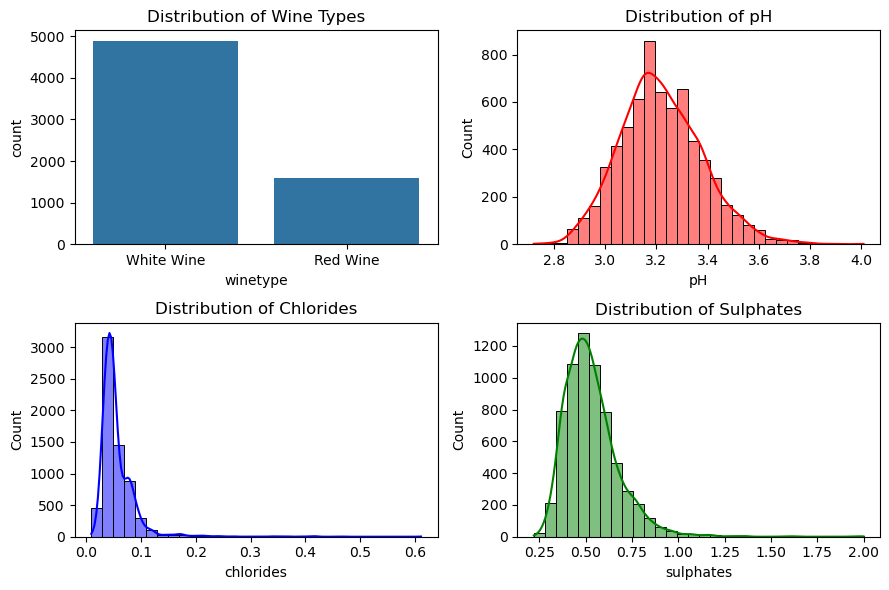

In [13]:
# Set up the figure size
plt.figure(figsize=(9, 6))

# Plot for 'winetype' column (the target feature)
plt.subplot(2, 2, 1)
sns.countplot(x='winetype', data=wine_df)
plt.xticks([0, 1], ['White Wine', 'Red Wine'])
plt.title('Distribution of Wine Types')

# Plot for 'pH' column
plt.subplot(2, 2, 2) 
sns.histplot(wine_df['pH'], kde=True, bins=30, color='red')
plt.title('Distribution of pH')

# Plot for 'chlorides' column
plt.subplot(2, 2, 3) 
sns.histplot(wine_df['chlorides'], kde=True, bins=30, color='blue')
plt.title('Distribution of Chlorides')

# Plot for 'sulphates' column
plt.subplot(2, 2, 4) 
sns.histplot(wine_df['sulphates'], kde=True, bins=30, color='green')
plt.title('Distribution of Sulphates')

# Show the plots
plt.tight_layout() # Adjust layout for better spacing
plt.show()

My observations on the distributions:

- We have a lot more data for white wine than red wine in our dataset. 
- pH distribution of wines is rather symmetric but with positive kurtosis (thin tails)
- chlorides and sulphates distribution are right skewed with positive kurtosis (thin tails)

## B4.  Build and evaluate Logistic Regression, Penalized Logistic Regression, and KNN models

First, let's import all additional libaries needed for questions B4 to B6:

In [14]:
# Import required libraries not already imported in Part A
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

### Split data into training and test sets

In [15]:
# Define the target column (y) and the feature columns (X)
y = wine_df['winetype']
X = wine_df.loc[:, wine_df.columns != 'winetype'] # all columns except winetype

# Split the data into training and test sets (By default: 75% training, 25% test)
X_trainB, X_testB, y_trainB, y_testB = train_test_split(X, y, random_state=42)

# Print the shape of the resulting sets
print('Training set X:', X_train.shape)
print('Test set X:', X_test.shape)
print('Training set Y:', y_train.shape)
print('Test set Y:', y_test.shape)

Training set X: (315, 10)
Test set X: (105, 10)
Training set Y: (315,)
Test set Y: (105,)


### Build and evaluate the 3 models

Below, we first create `modelsB`. It is a list of tuples, each containing a model's name and the model with input arguments. 

Then, pass this `modelsB` list and our training data into the `evaluate_models()` function we defined in our answer to question A4.

In [16]:
# List the models. By default, C = 1 for logistic regressions
# Use newton-cholesky not liblinear for no penalty case as recommended in docs
# All 4 models default to 'accuracy' scoring method
modelsB = [
    ('Logistic Regression', 
     LogisticRegression(penalty=None, solver='newton-cholesky', max_iter=1000)),
    
    ('L1-penalized Logistic Regression', 
     LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)),
    
    ('L2-penalized Logistic Regression', 
     LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)),
    
    # As winetype is binary use KNeighborsClassifier not KNeighborsRegressor
    ('KNN', KNeighborsClassifier()) # By default, n_neighbors=5
]

# Evaluate models without StandardScaler using cross-validation
results_no_scalingB = evaluate_models(X_trainB, y_trainB, modelsB, scaling=False)
results_no_scalingB

,Model,Mean Score,Standard Deviation
0,Logistic Regression,0.994,0.002
1,L1-penalized Logistic Regression,0.987,0.004
2,L2-penalized Logistic Regression,0.982,0.003
3,KNN,0.942,0.007


**Evaluation**:
- Logistic regression appears to be the best model with the highest mean accuracy score of 0.994. Given the small standard deviation of 0.002, this is likely significantly higher than the next best score of 0.986.
- The next best models are the L1 and L2-penalized logistic regression. Though the L1-penalized logistic regression performs slightly better than the L2, the difference is small (0.004) and may not be significant.
- KNN performs signficantly worse, with a mean accuracy score of 0.942.

## B5. Run the 4 models with and without `StandardScaler`

In [17]:
# Evaluate models with StandardScaler
results_scalingB = evaluate_models(X_trainB, y_trainB, modelsB, scaling=True)

# Add a new column to each DataFrame indicating whether scaling was applied
results_no_scalingB['Scaling'] = 'No'
results_scalingB['Scaling'] = 'Yes'

# Combine the two DataFrames and display results
combined_resultsB = pd.concat([results_no_scalingB, results_scalingB])
combined_resultsB.sort_values(by='Model').reset_index(drop=True)

,Model,Mean Score,Standard Deviation,Scaling
0,KNN,0.942,0.007,No
1,KNN,0.992,0.001,Yes
2,L1-penalized Logistic Regression,0.987,0.004,No
3,L1-penalized Logistic Regression,0.994,0.002,Yes
4,L2-penalized Logistic Regression,0.982,0.003,No
5,L2-penalized Logistic Regression,0.993,0.003,Yes
6,Logistic Regression,0.994,0.002,No
7,Logistic Regression,0.994,0.002,Yes


Summary and explanation of whether `StandardScaler` helps for each of the models:

- KNN: helps a lot
    - Scaling raises the mean accuracy score from 0.942 to 0.992, and lowers standard deviation from 0.007 to 0.001.
    - Again, this is because KNN is distance-based and scale-variant.
    - Without scaling, features like "residual sugar" (which might have large numerical values) will disproportionately influence the distance calculations, while features like "pH" (with smaller numerical values) will be almost ignored. Scaling fixes this.
- L1 and L2 penalized logistic regression: helps
    - Scaling raises L1-penalty's mean accuracy from 0.986 to 0.994, and L2-penalty's mean accuracy from 0.982 to 0.993.
    - The L1 and L2 penalties are sensitive to the magnitude and thus the units of feature values. Without scaling, features with larger ranges might dominate the penalty term, leading to suboptimal performance. To prevent unequal penalization across features, scaling is needed.
- Logistic regression: does not help
    - The logistic regression without penalty inherently adjusts its feature coefficients to account for different feature scales, so is not affected by scaling. Thus, scaling the data does not help to improve accuracy.


## B6. Use `GridSearchCV` to tune model parameters

Note that plain Logistic Regression has no model parameters that require tuning. However, we still include it below so that its results can be directly compared to the other models in a nice table.

We define the models and parameter grids of interest to test in the dictionary `models_and_paramsB`. We pass this along with our test and training datasets into the `evaluate_models2` function we defined in question A6 to tune and evaluate the models using `GridSearchCV`.

In [18]:
# Define the models and their parameter grids
models_and_paramsB = {
    'Logistic Regression': (
        LogisticRegression(penalty=None, solver='newton-cholesky'),  
        {}  # No parameters to tune for plain Logistic Regression
    ),
    'L1-penalized Logistic Regression': (
        LogisticRegression(penalty='l1', solver='liblinear'),
        {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
    ),
    'L2-penalized Logistic Regression': (
        LogisticRegression(penalty='l2', solver='liblinear'),
        {'logisticregression__C': [0.01, 0.1, 1, 10, 100]} 
    ),
    'KNN': (
        KNeighborsClassifier(),
        {'kneighborsclassifier__n_neighbors': np.arange(1, 15, 2)}
    )
}

# Evaluate models without scaling
results_no_scaling2B = evaluate_models2(
    X_trainB, y_trainB, X_testB, y_testB,
    models_and_paramsB, scaling=False
)

# Evaluate models with scaling
results_scaling2B = evaluate_models2(
    X_trainB, y_trainB, X_testB, y_testB,
    models_and_paramsB, scaling=True
)

# Combine results into a single DataFrame for comparison
combined_tuned_resultsB = pd.concat([
    results_no_scaling2B.assign(Scaling='No'),
    results_scaling2B.assign(Scaling='Yes')
], ignore_index=True)

# Display the results in a table format
combined_tuned_resultsB.sort_values(by='Model').reset_index(drop=True)

,Model,Best training set score,Best Parameter,Test set score,Scaling
0,KNN,0.943,{'kneighborsclassifier__n_neighbors': 1},0.950,No
1,KNN,0.993,{'kneighborsclassifier__n_neighbors': 13},0.992,Yes
2,L1-penalized Logistic Regression,0.988,{'logisticregression__C': 100},0.985,No
3,L1-penalized Logistic Regression,0.994,{'logisticregression__C': 1},0.993,Yes
4,L2-penalized Logistic Regression,0.988,{'logisticregression__C': 100},0.986,No
5,L2-penalized Logistic Regression,0.994,{'logisticregression__C': 100},0.993,Yes
6,Logistic Regression,0.994,N/A,0.993,No
7,Logistic Regression,0.994,N/A,0.993,Yes


Effects of parameter tuning:

- KNN: no significant change in performance.
    - Score changed from 0.942 (unscaled)/ 0.992 (scaled) with default parameters to 0.943 (unscaled)/ 0.993 (scaled) with tuned parameters.
- L1-penalized Logistic Regression: no significant change in performance.
    - L1-penalized logistic regression's score changed from 0.986 (unscaled)/ 0.994 (scaled) to 0.986 (unscaled)/ 0.993 (scaled).
- L2-penalized Logistic Regression: no significant change in performance
    - L2-penalized logistic regression's score changed from 0.982 (unscaled)/ 0.993 (scaled) to 0.986 (unscaled)/ 0.993 (scaled).
- Logistic regression: score is unaffected at 0.994, since there are no parameters to tune for plain logistic regressions.
- No significant performance change suggests that while the default parameters were not the best (except for scaled L1-penalized logistic regression where the default is the best), they work sufficiently well.


Effects of scaling:

- KNN: scaling greatly improves performance.
- L1 and L2-penalized Logistic Regression: scaling improves performance slightly.
- Logistic regression: scaling does not affect performance at all.

## B7. Compare plain and penalized Logistic Regression's coefficients

To compare coefficients and see if the models agree on which features are important, I create a feature ranking for each model based on absolute values of coefficients and include them alongside coefficient values for each model in a table:


In [19]:
# Fit plain and penalized logistic regression models with the best parameters
plain_logreg = LogisticRegression(penalty=None, solver='newton-cholesky') \
    .fit(X_trainB, y_trainB)
l1_logreg = LogisticRegression(penalty='l1', solver='liblinear', C=100) \
    .fit(X_trainB, y_trainB)
l2_logreg = LogisticRegression(penalty='l2', solver='liblinear', C=100) \
    .fit(X_trainB, y_trainB)

# Create a DataFrame to compare coefficients
coeff_dfB = pd.DataFrame({
    'Feature': X_trainB.columns,  # feature names
    'Plain Logreg Coeff': plain_logreg.coef_.flatten(), # flatten to 2D to 1D
    'L1-penalized Logreg Coeff': l1_logreg.coef_.flatten(),
    'L2-penalized Logreg Coeff': l2_logreg.coef_.flatten()
})

# Rank feature importance based on the absolute coefficients
coeff_dfB['Plain Logreg Ranking'] = coeff_dfB['Plain Logreg Coeff'].abs() \
    .rank(ascending=False, method='min')
coeff_dfB['L1 Logreg Ranking'] = coeff_dfB['L1-penalized Logreg Coeff'].abs() \
    .rank(ascending=False, method='min')
coeff_dfB['L2 Logreg Ranking'] = coeff_dfB['L2-penalized Logreg Coeff'].abs() \
    .rank(ascending=False, method='min')

# Sort and display the DataFrame by plain logreg's ranking for easier comparison
coeff_dfB.sort_values(by='Plain Logreg Ranking').reset_index(drop=True)

,Feature,Plain Logreg Coeff,L1-penalized Logreg Coeff,L2-penalized Logreg Coeff,Plain Logreg Ranking,L1 Logreg Ranking,L2 Logreg Ranking
0,density,1901.269053,-17.284706,-18.010805,1.0,2.0,2.0
1,chlorides,22.357797,29.737645,27.500290,2.0,1.0,1.0
2,volatile acidity,6.953098,12.049084,11.829468,3.0,3.0,3.0
3,citric acid,-3.199158,-1.167589,-1.144809,4.0,7.0,7.0
4,sulphates,2.887617,8.910945,8.760650,5.0,4.0,4.0
5,alcohol,1.936320,-0.444277,-0.464461,6.0,8.0,8.0
6,pH,-1.792483,7.701596,8.381739,7.0,5.0,5.0
7,residual sugar,-1.167749,-0.103138,-0.094890,8.0,9.0,9.0
8,fixed acidity,-0.303051,1.312008,1.352368,9.0,6.0,6.0
9,quality,0.211441,0.000388,-0.023352,10.0,12.0,12.0


Observations on ranking of feature importance:

- L1 and L2-penalized logistic regressions have the exact same ranking on feature importance among the 12 features used for prediction, though coefficient values differ.
- The top 3 most important features for prediction of wine type across both plain and penalized logistic regression models are `density`, `chlorides`, and `volatile acidity`.
- However, the ranking for the top and second most important feature is flipped. `density` is most important in plain logistic regression, while `chlorides` is most important in penalized logisitic regression.
- The top 3 least important features for prediction of wine type across both plain and penalized logistic regression models are `quality`, `free sulfur dioxide` and `total sulfur dioxide`.

Observations on the coefficients:

- The plain logistic regression has an extremely large positive coefficient on `density`, almost 100 times the size of the next largest coefficient 22 for `chlorides`. Under this model, wine type is thus almost completely predicted by `density`, with higher values associated with red wine.
- The penalized logistic regressions penalize excessively large coefficients and does not have too large coefficients. That being said, the top 4 features have much higher coefficients compared to the other features.
- `Density` has a negative coefficient in penalized regressions, which is directionally opposite of the coefficient in a plain logistic regression.

## B8. Final model you would choose to predict new data

We will use `Test set score` to assess the predictive power of the various models. Let's sort our models with tuned parameters by `Test set score`:

In [20]:
# Sort the final results by the 'Test set score' in descending order
combined_tuned_resultsB.sort_values(by='Test set score', ascending=False)

,Model,Best training set score,Best Parameter,Test set score,Scaling
0,Logistic Regression,0.994,N/A,0.993,No
4,Logistic Regression,0.994,N/A,0.993,Yes
5,L1-penalized Logistic Regression,0.994,{'logisticregression__C': 1},0.993,Yes
6,L2-penalized Logistic Regression,0.994,{'logisticregression__C': 100},0.993,Yes
7,KNN,0.993,{'kneighborsclassifier__n_neighbors': 13},0.992,Yes
2,L2-penalized Logistic Regression,0.988,{'logisticregression__C': 100},0.986,No
1,L1-penalized Logistic Regression,0.988,{'logisticregression__C': 100},0.985,No
3,KNN,0.943,{'kneighborsclassifier__n_neighbors': 1},0.950,No


Scaling does not affect plain logistic regression at all, so let's ignore the unscaled plain logistic regression. Plain logistic regression, L1 and L2-penalized logistic regression appear to have near identical performance (to 3 decimal places). 

I will **choose plain logistic regression model** to predict new data because:
- it has the best test set score, alongside L1 and L2-penalized logistic regression
- it is simpler (more parsimonous) compared to L1 and L2-penalized logistic regression, and thus likely requires less computing power when working with big data.